<a href="https://colab.research.google.com/github/ali-f-alfa/Persian-Handwriting-Recognition/blob/main/Persian_Handwriting_Character_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
import numpy as np
import os
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
from scipy.ndimage import rotate
from keras import backend as K
from keras.models import Model,Sequential
from keras.layers import Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Reshape,GlobalAveragePooling2D,ZeroPadding2D,MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.layers import Bidirectional, LSTM
from keras.layers import Lambda, Activation, BatchNormalization,Add
# from keras.optimizers import Adam,SGD
from tensorflow.keras.optimizers import Adam,SGD
from keras.layers import Flatten
from keras.initializers import glorot_uniform
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from google.colab.patches import cv2_imshow

### Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract Dataset from Drive
# !unrar x "/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/Dataset/Isolated_Letters.rar"
!unrar x "/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/Dataset/Isolated_Letters_small.rar"
# !unrar x "/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/Dataset/Isolated_Letters_small.rar"

Streaming output truncated to the last 5000 lines.
Extracting  Isolated Letters/SIN/ID0000109_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID000010_p3_B18.tif                      71%  OK 
Extracting  Isolated Letters/SIN/ID0000110_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000111_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000112_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000113_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000114_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000115_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000116_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/SIN/ID0000117_p3_B18.tif                     71%  OK 
Extracting  Isolated Letters/

## Create Dataset

In [ ]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [ ]:
IMG_WIDTH=64
IMG_HEIGHT=64
img_folder='/content/Isolated Letters'

In [ ]:
img_data, class_name =create_dataset(img_folder)
print(np.unique(class_name))
print(len(class_name))
print(len(img_data))

['ALEF_B' 'ALEF_S' 'BE' 'CHE' 'DAL' 'EIN' 'FAF' 'GAF' 'GHAF' 'GHEIN' 'HE'
 'HE2' 'HE2_S' 'JIM' 'KAF' 'KHE' 'LAM' 'MIM' 'NON' 'PE' 'RE' 'SAD' 'SE'
 'SHIN' 'SIN' 'TA' 'TE' 'VAV' 'YEH' 'ZA' 'ZAD' 'ZAL' 'ZHE' 'Ze']
16996
16996


In [ ]:
print(class_name[0])
print(img_data[0][10])

GHAF
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.39215687 0.         0.         0.         0.34117648
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.77254903 0.         0.         0.         0.19215687
 0.77254903 1.         1.         1.        ]


## Resnet Model

In [ ]:
model = Sequential()
model.add(tf.keras.applications.ResNet50(include_top = False,
                                         pooling = "avg",
                                         weights = None,
                                         input_shape=(64, 64, 1)))
model.add(Dense(34, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23581440  
                                                                 
 dense (Dense)               (None, 34)                69666     
                                                                 
Total params: 23,651,106
Trainable params: 23,597,986
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
DATA_TRAIN_PATH='/content/Isolated Letters/'
IMG_WIDTH = 64
IMG_HEIGHT = 64
EPOCHS=150
BATCH_SIZE=128
# train_generator  = train_datagen.flow_from_directory(
#         DATA_TRAIN_PATH,
#         target_size=(IMG_WIDTH, IMG_HEIGHT),
#         batch_size=BATCH_SIZE,
#         class_mode='categorical')

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rotation_range=20, fill_mode='nearest',
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   brightness_range=[0.5,1.5],
                                   zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH, # same directory as training data
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 13600 images belonging to 34 classes.
Found 3396 images belonging to 34 classes.


In [ ]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
model.compile(loss= loss, optimizer= optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model_BestSave3.h5",
                             monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')


In [ ]:
# H = model.fit(train_generator, epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=True)
H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks=[checkpoint])


<ipython-input-10-e4747ebc164b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/150
106/106 [==============================] - ETA: 0s - loss: 2.5727 - accuracy: 0.2937
Epoch 1: val_accuracy improved from -inf to 0.03335, saving model to /content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model_BestSave3.h5
106/106 [==============================] - 79s 324ms/step - loss: 2.5727 - accuracy: 0.2937 - val_loss: 6.5423 - val_accuracy: 0.0334
Epoch 2/150
106/106 [==============================] - ETA: 0s - loss: 1.1188 - accuracy: 0.6354
Epoch 2: val_accuracy improved from 0.03335 to 0.30319, saving model to /content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model_BestSave3.h5
106/106 [==============================] - 32s 306ms/step - loss: 1.1188 - accuracy: 0.6354 - val_loss: 3.3342 - val_accuracy: 0.3032
Epoch 3/150
106/106 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.7614
Epoch 3: val_accuracy improved from 0.30319 to 0.60637, saving model to /content/drive/MyDrive/Final

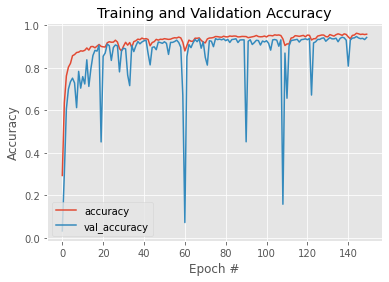

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

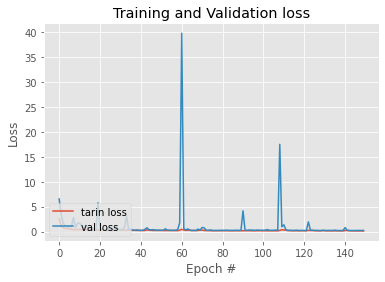

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["loss"], label="tarin loss")
plt.plot(N, H.history["val_loss"], label="val loss")
plt.title("Training and Validation loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model.h5")
print("Saved model to disk")

Saved model to disk


### Load previous model

In [ ]:
json_file = open('/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_resnet_model.h5")
print("Loaded model from disk")

Loaded model from disk


### Test

1/1 [==============================] - 0s 44ms/step
ALEF_S


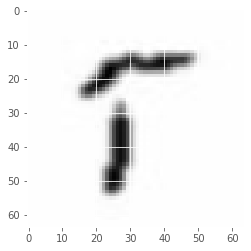

In [ ]:
image = cv2.imread("ALEF.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (64, 64))
image = np.expand_dims(image, axis=0)
list_dict_val = list((train_generator.class_indices.values()))
list_dict_key = list((train_generator.class_indices.keys()))

print(list_dict_key[list_dict_val.index(np.argmax(loaded_model.predict(image), axis=-1))])

plt.imshow(image[0], cmap='gray')

## VGG Model

In [4]:
model = Sequential()
model.add(tf.keras.applications.vgg16.VGG16(include_top = False,
                                         pooling = "avg",
                                         weights = None,
                                         input_shape=(64, 64, 1)))
model.add(Dense(34, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14713536  
                                                                 
 dense (Dense)               (None, 34)                17442     
                                                                 
Total params: 14,730,978
Trainable params: 14,730,978
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.preprocessing.image import ImageDataGenerator
DATA_TRAIN_PATH='/content/Isolated Letters/'
IMG_WIDTH = 64
IMG_HEIGHT = 64
EPOCHS=200
BATCH_SIZE=128

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rotation_range=20, fill_mode='nearest',
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   brightness_range=[0.5,1.5],
                                   zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH, # same directory as training data
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 13600 images belonging to 34 classes.
Found 3396 images belonging to 34 classes.


In [8]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
model.compile(loss= loss, optimizer= optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model_best1.h5",
                             monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [9]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks=[checkpoint])


<ipython-input-9-a024368499b1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/200
106/106 [==============================] - ETA: 0s - loss: 4.4007 - accuracy: 0.0256
Epoch 1: val_accuracy improved from -inf to 0.02945, saving model to /content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model_best1.h5
106/106 [==============================] - 48s 304ms/step - loss: 4.4007 - accuracy: 0.0256 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 2/200
106/106 [==============================] - ETA: 0s - loss: 3.5267 - accuracy: 0.0258
Epoch 2: val_accuracy did not improve from 0.02945
106/106 [==============================] - 28s 262ms/step - loss: 3.5267 - accuracy: 0.0258 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 3/200
106/106 [==============================] - ETA: 0s - loss: 3.5266 - accuracy: 0.0283
Epoch 3: val_accuracy did not improve from 0.02945
106/106 [==============================] - 29s 272ms/step - loss: 3.5266 - accuracy: 0.0283 - val_loss: 3.5264 - val_accuracy: 0.0294
Epoch 4/200
106/106 [======================

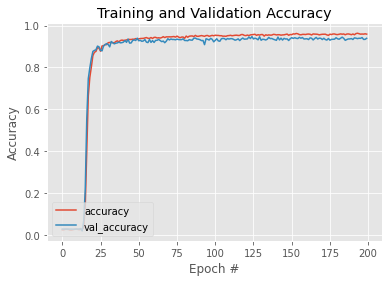

In [10]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["accuracy"], label="accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

### Save Model

In [11]:
model_json = model.to_json()
with open("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model.h5")
print("Saved model to disk")

Saved model to disk


### Load Model

In [12]:
json_file = open('/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model.h5")
print("Loaded model from disk")

Loaded model from disk


### Test

1/1 [==============================] - 0s 21ms/step
ZAL


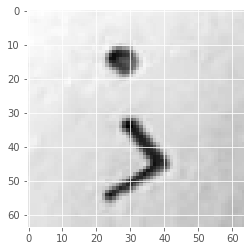

In [38]:
image = cv2.imread("ZAL.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (64, 64))
image = np.expand_dims(image, axis=0)
list_dict_val = list((train_generator.class_indices.values()))
list_dict_key = list((train_generator.class_indices.keys()))

print(list_dict_key[list_dict_val.index(np.argmax(loaded_model.predict(image), axis=-1))])

plt.imshow(image[0], cmap='gray')

## Small Model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()

model.add(Conv2D(128, kernel_size=5, activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(64, kernel_size=3, activation="relu"))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(34, activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 60, 60, 128)       3328      
                                                                 
 conv2d_18 (Conv2D)          (None, 58, 58, 64)        73792     
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 32)        18464     
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 34)                3412002   
                                                                 
Total params: 3,507,586
Trainable params: 3,507,586
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.preprocessing.image import ImageDataGenerator
DATA_TRAIN_PATH='/content/Isolated Letters/'
IMG_WIDTH = 64
IMG_HEIGHT = 64
EPOCHS=300
BATCH_SIZE=128

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rotation_range=10, fill_mode='nearest',
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   brightness_range=[0.5,1.5],
                                   zoom_range=0.3)

train_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    DATA_TRAIN_PATH, # same directory as training data
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode = "grayscale",
    seed = 2020,
    shuffle=True,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 13600 images belonging to 34 classes.
Found 3396 images belonging to 34 classes.


In [12]:
loss = 'categorical_crossentropy'
optimizer = 'adam'
model.compile(loss= loss, optimizer= optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint("/content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model_best1.h5",
                             monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks=[checkpoint])


<ipython-input-13-a024368499b1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/300
106/106 [==============================] - ETA: 0s - loss: 5.8906 - accuracy: 0.1883
Epoch 1: val_accuracy improved from -inf to 0.28335, saving model to /content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model_best1.h5
106/106 [==============================] - 40s 277ms/step - loss: 5.8906 - accuracy: 0.1883 - val_loss: 2.6636 - val_accuracy: 0.2834
Epoch 2/300
106/106 [==============================] - ETA: 0s - loss: 2.3614 - accuracy: 0.3386
Epoch 2: val_accuracy improved from 0.28335 to 0.38882, saving model to /content/drive/MyDrive/FinalProject/PersianCharacterRecognition/character_vgg_model_best1.h5
106/106 [==============================] - 25s 231ms/step - loss: 2.3614 - accuracy: 0.3386 - val_loss: 2.1461 - val_accuracy: 0.3888
Epoch 3/300
106/106 [==============================] - ETA: 0s - loss: 2.0013 - accuracy: 0.4211
Epoch 3: val_accuracy improved from 0.38882 to 0.43720, saving model to /content/drive/MyDrive/FinalProject/Persia